In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8-whitegrid')
%matplotlib inline

# metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error


from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.neural_network import MLPRegressor
from sklearn import tree
from sklearn import svm
from sklearn import neighbors
from sklearn import linear_model
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
import catboost as cb
pd.set_option('display.max_columns', None)

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import MinMaxScaler, StandardScaler, PowerTransformer

In [2]:
# import data 
df = pd.read_csv("../Austin/ames_house_price_encoded.csv")


df.head()

target = df['sale_price']
features = df.drop(['sale_price', 'pid', 'bc_sale_price'], axis = 1)

In [18]:
features

,gr_liv_area,lot_frontage,lot_area,lot_shape,utilities,land_slope,overall_qual,overall_cond,mas_vnr_area,exter_qual,exter_cond,bsmt_qual,bsmt_cond,bsmt_exposure,bsmt_fin_type1,bsmt_fin_sf1,bsmt_fin_type2,bsmt_fin_sf2,bsmt_unf_sf,total_bsmt_sf,heating_qc,central_air,electrical,1st_flr_sf,2nd_flr_sf,low_qual_fin_sf,bsmt_full_bath,bsmt_half_bath,full_bath,half_bath,bedroom_abv_gr,kitchen_abv_gr,kitchen_qual,tot_rms_abv_grd,functional,fireplaces,fireplace_qu,garage_finish,garage_cars,garage_area,garage_qual,garage_cond,paved_drive,wood_deck_sf,open_porch_sf,enclosed_porch,3_ssn_porch,screen_porch,pool_area,pool_qc,fence,misc_val,mo_sold,street_grvl,alley_grvl,alley_pave,land_contour_bnk,land_contour_hls,land_contour_low,lot_config_corner,lot_config_culdsac,lot_config_fr2,lot_config_fr3,neighborhood_blmngtn,neighborhood_blueste,neighborhood_brdale,neighborhood_brkside,neighborhood_clearcr,neighborhood_collgcr,neighborhood_crawfor,neighborhood_edwards,neighborhood_gilbert,neighborhood_greens,neighborhood_grnhill,neighborhood_idotrr,neighborhood_landmrk,neighborhood_meadowv,neighborhood_mitchel,neighborhood_npkvill,neighborhood_nwames,neighborhood_noridge,neighborhood_nridght,neighborhood_oldtown,neighborhood_swisu,neighborhood_sawyer,neighborhood_sawyerw,neighborhood_somerst,neighborhood_stonebr,neighborhood_timber,neighborhood_veenker,near_rr,near_main_rd,near_pos,bldg_type_2fmcon,bldg_type_duplex,bldg_type_twnhs,bldg_type_twnhse,house_style_1.5fin,house_style_1.5unf,house_style_2.5fin,house_style_2.5unf,house_style_2story,house_style_sfoyer,house_style_slvl,roof_style_flat,roof_style_gambrel,roof_style_hip,roof_style_mansard,roof_style_shed,roof_matl_membran,roof_matl_metal,roof_matl_roll,roof_matl_tar&grv,roof_matl_wdshake,roof_matl_wdshngl,exterior1st_asbshng,exterior1st_asphshn,exterior1st_brkcomm,exterior1st_brkface,exterior1st_cblock,exterior1st_cemntbd,exterior1st_hdboard,exterior1st_imstucc,exterior1st_metalsd,exterior1st_plywood,exterior1st_precast,exterior1st_stucco,exterior1st_wd sdng,exterior1st_wdshing,exterior2nd_asbshng,exterior2nd_asphshn,exterior2nd_brk cmn,exterior2nd_brkface,exterior2nd_cblock,exterior2nd_cmentbd,exterior2nd_hdboard,exterior2nd_imstucc,exterior2nd_metalsd,exterior2nd_plywood,exterior2nd_precast,exterior2nd_stone,exterior2nd_stucco,exterior2nd_wd sdng,exterior2nd_wd shng,mas_vnr_type_brkcmn,mas_vnr_type_brkface,mas_vnr_type_stone,foundation_brktil,foundation_pconc,foundation_slab,foundation_stone,foundation_wood,heating_floor,heating_gasw,heating_grav,heating_othw,heating_wall,garage_type_2types,garage_type_basment,garage_type_builtin,garage_type_carport,garage_type_detchd,garage_type_na,misc_feature_gar2,misc_feature_othr,misc_feature_shed,misc_feature_tenc,sale_type_cod,sale_type_cwd,sale_type_con,sale_type_conld,sale_type_conli,sale_type_conlw,sale_type_new,sale_type_oth,sale_type_vwd,sale_condition_abnorml,sale_condition_adjland,sale_condition_alloca,sale_condition_family,sale_condition_partial,ms_sub_class_120,ms_sub_class_150,ms_sub_class_160,ms_sub_class_180,ms_sub_class_190,ms_sub_class_30,ms_sub_class_40,ms_sub_class_45,ms_sub_class_50,ms_sub_class_60,ms_sub_class_70,ms_sub_class_75,ms_sub_class_80,ms_sub_class_85,ms_sub_class_90,ms_zoning_a (agr),ms_zoning_c (all),ms_zoning_fv,ms_zoning_i (all),ms_zoning_rh,ms_zoning_rm,house_age_at_sale,construction_age_at_sale,yr_sold_2007,yr_sold_2008,yr_sold_2009,yr_sold_2010
0,856,80.0,7890,4,2,3,6,6,0.0,3,3,3,3,1,3,238.0,1,0.0,618.0,856.0,3,1,4,856,0,0,1.0,0.0,1,0,2,1,3,4,7,1,4,1,2.0,399.0,3,3,3,0,0,0,0,166,0,0,0,0,3,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,71,60,0,0,0,1
1,1049,42.0,4235,4,2,3,5,5,149.0,4,3,4,3,2,6,552.0,5,393.0,104.0,1049.0,3,1,4,1049,0,0,1.0,0.0,2,0,2,1,4,5,7,0,0,3,1.0,266.0,3,

In [3]:
# Define custom scaler function
def scale_feature_log_dependent(scaler, X, y):
    X_scaler = scaler
    X_scaler.fit(X=X,y=y)
    X_scaled = X_scaler.transform(X)
    
    # log transformation is good for the dependent variable
    y_scaled = np.log(y)
    
    return X_scaled, y_scaled, X_scaler


def scale_feature_only(scaler, X_train, y_train, X_test):
    X_scaler = scaler
    X_scaler.fit(X=X,y=y_train)
    X_train_scaled = X_scaler.transform(X_train)
    X_test_scaled = X_scaler.transform(X_test)
    return X_train_scaled, X_test_scaled, X_scaler

In [4]:
# Define custom scaler backtransform

#def rmse_with_inv_transform(scaler, y_test, y_pred_scaled, model_name, error_type = 'Test'):
    
#    # test (exponentiate the y_preds rather than inverse transform given that I am not applying the same scaler to the response variable as is to the feature dataset)
#    y_predict = scaler.inverse_transform(y_pred_scaled.reshape(-1,1))
#    
#    rmse_error = mean_squared_error(y_test, y_predict[:,0], squared=False)
#    print(error_type + " " + "Error = "'{}'.format(rmse_error)+ " in " + model_name)
#    return rmse_error, y_predict

In [5]:
# Custom function to run baseline models and report error

def make_regression(X_train, y_train, X_test, y_test, model, model_name, verbose=False, ylog = False):
    """Apply selected regression model to data and measure error"""
    model.fit(X_train, y_train)
    
    # Train / Test Predictions
    y_predict_train = model.predict(X_train)
    y_predict = model.predict(X_test)
    
    if ylog:
        y_predict_train = np.exp(y_predict_train)
        y_predict = np.exp(y_predict)
        y_train = np.exp(y_train)
        y_test = np.exp(y_test)
        
        #TRAIN ylog
        train_RMSE = mean_squared_error(y_train, y_predict_train, squared=False)
        # MAPE  
        train_MAPE = mean_absolute_percentage_error(y_train, y_predict_train)*100
        # MAE
        train_MAE = mean_absolute_error(y_train, y_predict_train)
        
        # TEST ylog
        test_RMSE = mean_squared_error(y_test, y_predict, squared=False)
    
        # MAPE ylog 
        test_MAPE = mean_absolute_percentage_error(y_test, y_predict)*100
        # MAE
        test_MAE = mean_absolute_error(y_test, y_predict)
    
    #TRAIN
    train_RMSE = mean_squared_error(y_train, y_predict_train, squared=False)
    # MAPE
    train_MAPE = mean_absolute_percentage_error(y_train, y_predict_train)*100
    # MAE
    train_MAE = mean_absolute_error(y_train, y_predict_train)
    
    # TEST
    test_RMSE = mean_squared_error(y_test, y_predict, squared=False)
    
    # MAPE ylog 
    test_MAPE = mean_absolute_percentage_error(y_test, y_predict)*100
    # MAE
    test_MAE = mean_absolute_error(y_test, y_predict)
    
    if verbose:
        print("Train RMSE = "'{}'.format(train_RMSE)+" in " + model_name)
        print("Test RMSE = "'{}'.format(test_RMSE)+" in " + model_name)
        print("Train MAPE = "'{}'.format(train_MAPE)+" in " + model_name)
        print("Test MAPE = "'{}'.format(test_MAPE)+" in " + model_name)
        print("Train MAE = "'{}'.format(train_MAE)+" in " + model_name)
        print("Test MAE = "'{}'.format(test_MAE)+" in " + model_name)
    trained_model = model
    
    return trained_model, y_predict, y_predict_train, train_RMSE, test_RMSE, train_MAPE, test_MAPE, train_MAE, test_MAE

In [10]:
# scale or not scale dependent variable

y = target
ylog = False

# Define an empty prediction dictionary
pred_dict = {
    'regression_model':[],
    'scaler_name':[],
    'feature_set':[],
    'Train RMSE': [],
    'Test RMSE':[],
    'Train MAPE':[],
    'Test MAPE':[],
    'Train MAE':[],
    'Test MAE': []
}

# List the regression models for testing
regression_models = {
    #"MLR": linear_model.LinearRegression(),
    "Ridge": linear_model.Ridge(), # expect feature set to be normalized
    "Lasso": linear_model.Lasso(max_iter = 10000), # expect feature set to be normalized
    #"Elastic-Net": linear_model.ElasticNet(), # expect feature set to be normalized
    
    # Tree based models
    "RandomForest": RandomForestRegressor(n_estimators=500, max_depth = 10),
    # Gradient Boosted
    "XGBoost": XGBRegressor(n_estimators=500, max_depth = 10, learning_rate = 0.1),
    "CatBoost": cb.CatBoostRegressor(n_estimators=500,verbose=False, depth = 10,learning_rate = 0.1),
    "LGBM": LGBMRegressor(n_estimators=500, max_depth = 10, learning_rate = 0.1),
    #"AdaBoost": AdaBoostRegressor(n_estimators=500, learning_rate = 0.05)
}


# FEATURE SET SCALERS
scalers = {
    'NotScale': None,
    'Standard': StandardScaler(),
    'yeo-johnson': PowerTransformer(),
#    'MinMax': MinMaxScaler(), # not normally applied to dependent variable, performs the poorest so will eliminate


}

feature_sets = {
    "full": features.columns.to_list()
}

In [11]:
for feature_set_name in feature_sets.keys():
    feature_set = feature_sets[feature_set_name]
    # subset X based on the current feature set
    X = features[feature_set]
    
    # Perform train / test / split
    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.25, random_state = 42)
    
    for scaler_name in scalers.keys():
        print(f"-----scaled with {scaler_name}----- included columns are {feature_set_name}")
        print("")
        
        for model_name in regression_models.keys():
            if scaler_name == "NotScale":
                _, _, _, train_RMSE, test_RMSE, train_MAPE, test_MAPE, train_MAE, test_MAE = \
                    make_regression(X_train, y_train, X_test, y_test, \
                                    regression_models[model_name], model_name, ylog=ylog)
                
            else:
                X_train_scaled, X_test_scaled, X_scaler = \
                    scale_feature_only(scalers[scaler_name], X_train, y_train, X_test)
                
                # Run model
                _, _, _, train_RMSE, test_RMSE, train_MAPE, test_MAPE, train_MAE, test_MAE = \
                    make_regression(X_train_scaled, y_train, X_test_scaled, \
                                    y_test, regression_models[model_name], model_name, ylog=ylog)
            
            pred_dict["regression_model"].append(model_name)
            pred_dict["feature_set"].append(feature_set_name)
            pred_dict["scaler_name"].append(scaler_name)
            pred_dict["Train RMSE"].append(train_RMSE)
            pred_dict["Test RMSE"].append(test_RMSE)
            pred_dict["Train MAPE"].append(train_MAPE)
            pred_dict["Test MAPE"].append(test_MAPE)
            pred_dict["Train MAE"].append(train_MAE)
            pred_dict["Test MAE"].append(test_MAE)

-----scaled with NotScale----- included columns are full



/Users/eihwood/opt/miniforge3/envs/boost/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.627e+11, tolerance: 1.056e+09
  model = cd_fast.enet_coordinate_descent(


-----scaled with Standard----- included columns are full

-----scaled with yeo-johnson----- included columns are full



/Users/eihwood/opt/miniforge3/envs/boost/lib/python3.11/site-packages/numpy/core/_methods.py:239: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/Users/eihwood/opt/miniforge3/envs/boost/lib/python3.11/site-packages/numpy/core/_methods.py:250: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/Users/eihwood/opt/miniforge3/envs/boost/lib/python3.11/site-packages/numpy/core/_methods.py:239: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/Users/eihwood/opt/miniforge3/envs/boost/lib/python3.11/site-packages/numpy/core/_methods.py:250: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/Users/eihwood/opt/miniforge3/envs/boost/lib/python3.11/site-packages/numpy/core/_methods.py:239: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/Users/eihwood/opt/miniforge3/envs/boo

In [12]:
if ylog:
    pred_df_logy = pd.DataFrame(pred_dict)
    # Append a string to each row in a the scaler_name column
    column_name = 'scaler_name'
    suffix = '_logy'
    pred_df_logy[column_name] = pred_df_logy[column_name].apply(lambda x: x + suffix)

else:
    pred_df = pd.DataFrame(pred_dict)


pred_df_logy

,regression_model,scaler_name,feature_set,Train RMSE,Test RMSE,Train MAPE,Test MAPE,Train MAE,Test MAE
0,Ridge,NotScale_logy,full,20087.519611,20096.215927,6.855643,7.337439,11459.387713,13271.942915
1,Lasso,NotScale_logy,full,38275.157737,30555.663131,12.802187,11.748896,20944.973242,20642.672250
2,RandomForest,NotScale_logy,full,11524.317162,26312.357432,4.470931,8.945168,7648.078902,16240.331743
3,XGBoost,NotScale_logy,full,219.773466,21497.962634,0.081346,7.049225,136.015045,12939.704367
4,CatBoost,NotScale_logy,full,1866.705108,20400.648462,0.780151,7.257872,1350.926274,12984.261648
5,LGBM,NotScale_logy,full,2739.754418,23383.391979,1.142783,8.072778,1891.313335,14564.771719
6,Ridge,Standard_logy,full,19688.700062,20642.747201,6.822198,7.526074,11385.510378,13539.926400
7,Lasso,Standard_logy,full,74992.213030,80336.947637,31.343911,30.679119,52096.092374,54886.008779
8,RandomForest,Standard_logy,full,11457.636835,26135.366044,4.454149,8.995612,7633.577225,16266.343203
9,XGBoost,Standard_logy,full,219.773466,21507.247938,0.081346,7.054644,136.015045,12945.022814


In [13]:
pred_df_combined = pd.concat([pred_df, pred_df_logy]).reset_index(drop=True)# Concatenate or bind rows using concat()


## Plot Test RMSE

In [17]:
help(PowerTransformer)

Help on class PowerTransformer in module sklearn.preprocessing._data:

class PowerTransformer(sklearn.base.OneToOneFeatureMixin, sklearn.base.TransformerMixin, sklearn.base.BaseEstimator)
 |  PowerTransformer(method='yeo-johnson', *, standardize=True, copy=True)
 |  
 |  Apply a power transform featurewise to make data more Gaussian-like.
 |  
 |  Power transforms are a family of parametric, monotonic transformations
 |  that are applied to make data more Gaussian-like. This is useful for
 |  modeling issues related to heteroscedasticity (non-constant variance),
 |  or other situations where normality is desired.
 |  
 |  Currently, PowerTransformer supports the Box-Cox transform and the
 |  Yeo-Johnson transform. The optimal parameter for stabilizing variance and
 |  minimizing skewness is estimated through maximum likelihood.
 |  
 |  Box-Cox requires input data to be strictly positive, while Yeo-Johnson
 |  supports both positive or negative data.
 |  
 |  By default, zero-mean, uni

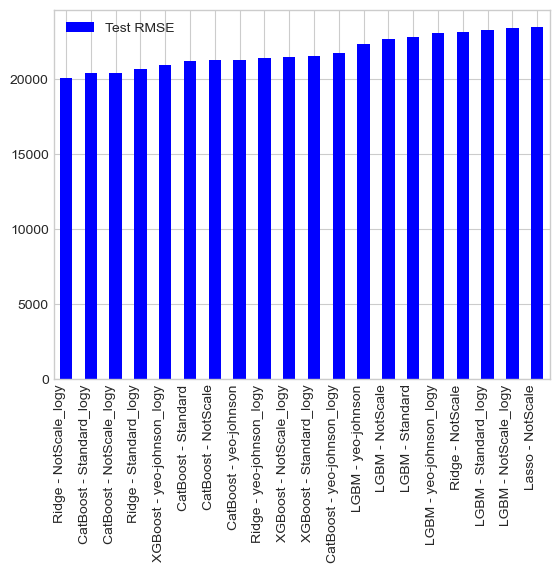

In [14]:
# Sort the DataFrame by 'Test RMSE' in ascending order
sorted_df = pred_df_combined.sort_values('Test RMSE').iloc[0:20,:]

# Create the bar plot
ax = sorted_df[['regression_model', 'scaler_name', 'Test RMSE']].plot(kind='bar', color='blue')

# Set the x-tick labels
x_labels = sorted_df.apply(lambda x: f"{x['regression_model']} - {x['scaler_name']}", axis=1).tolist()
ax.set_xticklabels(x_labels, rotation=90, ha='right')

#ax.title('R')

# Display the plot
plt.show()

## Plot Test MAPE

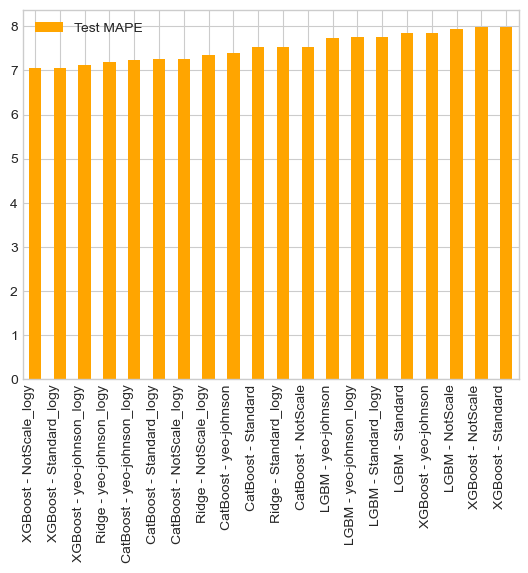

In [15]:
# Sort the DataFrame by 'Test RMSE' in ascending order
sorted_df = pred_df_combined.sort_values('Test MAPE').iloc[0:20,:]

# Create the bar plot
ax = sorted_df[['regression_model', 'scaler_name', 'Test MAPE']].plot(kind='bar', color='orange')

# Set the x-tick labels
x_labels = sorted_df.apply(lambda x: f"{x['regression_model']} - {x['scaler_name']}", axis=1).tolist()
ax.set_xticklabels(x_labels, rotation=90, ha='right')

#ax.title('R')

# Display the plot
plt.show()

## Plot Test MAE

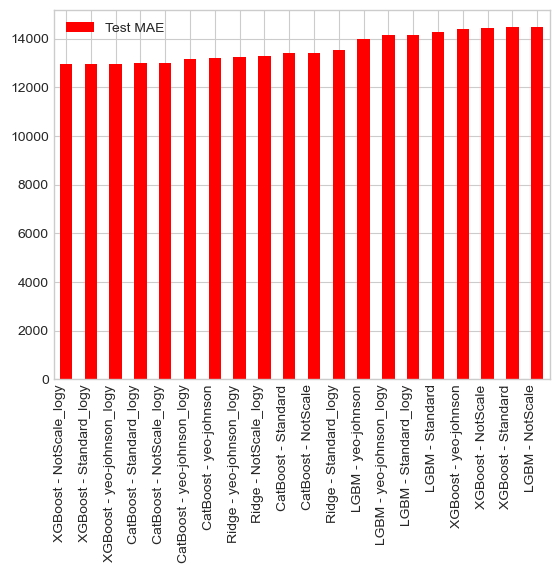

In [16]:
# Sort the DataFrame by 'Test RMSE' in ascending order
sorted_df = pred_df_combined.sort_values('Test MAE').iloc[0:20,:]

# Create the bar plot
ax = sorted_df[['regression_model', 'scaler_name', 'Test MAE']].plot(kind='bar', color='red')

# Set the x-tick labels
x_labels = sorted_df.apply(lambda x: f"{x['regression_model']} - {x['scaler_name']}", axis=1).tolist()
ax.set_xticklabels(x_labels, rotation=90, ha='right')

#ax.title('R')

# Display the plot
plt.show()